In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv(r"C:\Users\JMR\Downloads\stock_market_data.csv")  # <-- Change this to your dataset
# Check Data Structure
print(df.head())



         date       open       high        low      close   adjclose  volume  \
0  2022-01-03  17.799999  18.219000  17.500000  17.760000  17.760000  106600   
1  2022-01-04  17.700001  18.309999  17.620001  17.660000  17.660000  128700   
2  2022-01-05  17.580000  17.799999  16.910000  16.950001  16.950001  103100   
3  2022-01-06  16.650000  16.879999  16.139999  16.170000  16.170000  173600   
4  2022-01-07  16.219999  16.290001  15.630000  15.710000  15.710000  137800   

  ticker  RSIadjclose15  RSIvolume15  ...  high-15  K-15  D-15  \
0   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
1   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
2   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
3   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
4   ASLE            NaN          NaN  ...      NaN   NaN   NaN   

   stochastic-k-15  stochastic-d-15  stochastic-kd-15  volumenrelativo  \
0              NaN              NaN             

In [2]:
# Convert Date Column to Datetime
df.columns = df.columns.str.strip()
df.rename(columns={"close": "Close"}, inplace=True)
print(df.head())

         date       open       high        low      Close   adjclose  volume  \
0  2022-01-03  17.799999  18.219000  17.500000  17.760000  17.760000  106600   
1  2022-01-04  17.700001  18.309999  17.620001  17.660000  17.660000  128700   
2  2022-01-05  17.580000  17.799999  16.910000  16.950001  16.950001  103100   
3  2022-01-06  16.650000  16.879999  16.139999  16.170000  16.170000  173600   
4  2022-01-07  16.219999  16.290001  15.630000  15.710000  15.710000  137800   

  ticker  RSIadjclose15  RSIvolume15  ...  high-15  K-15  D-15  \
0   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
1   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
2   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
3   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
4   ASLE            NaN          NaN  ...      NaN   NaN   NaN   

   stochastic-k-15  stochastic-d-15  stochastic-kd-15  volumenrelativo  \
0              NaN              NaN             

Epoch 1/150
97/97 [==============================] - 17s 128ms/step - loss: 0.1440 - val_loss: 0.0082 - lr: 0.0010
Epoch 2/150
97/97 [==============================] - 12s 126ms/step - loss: 0.0401 - val_loss: 0.0016 - lr: 0.0010
Epoch 3/150
97/97 [==============================] - 12s 127ms/step - loss: 0.0187 - val_loss: 4.7416e-04 - lr: 0.0010
Epoch 4/150
97/97 [==============================] - 13s 135ms/step - loss: 0.0114 - val_loss: 2.7840e-04 - lr: 0.0010
Epoch 5/150
97/97 [==============================] - 12s 129ms/step - loss: 0.0070 - val_loss: 0.0014 - lr: 0.0010
Epoch 6/150
97/97 [==============================] - 12s 127ms/step - loss: 0.0051 - val_loss: 1.7848e-04 - lr: 0.0010
Epoch 7/150
97/97 [==============================] - 13s 129ms/step - loss: 0.0041 - val_loss: 2.5287e-04 - lr: 0.0010
Epoch 8/150
97/97 [==============================] - 12s 125ms/step - loss: 0.0035 - val_loss: 3.1753e-04 - lr: 0.0010
Epoch 9/150
97/97 [==============================] - 13s 132

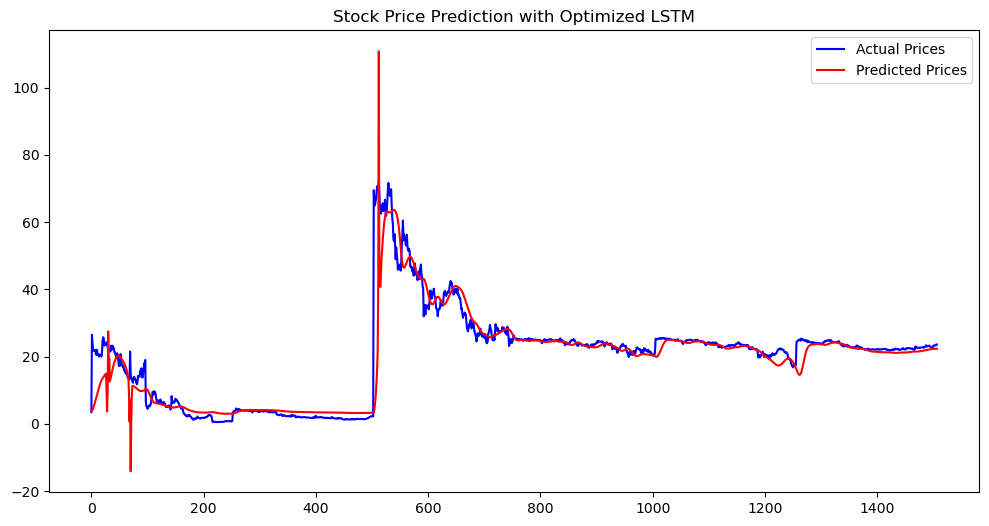

In [3]:
# ========================
# FEATURE ENGINEERING (Optional)
# ========================
# Example: Adding rolling mean as a new feature
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()
df.fillna(method='bfill', inplace=True)  # Fill missing values

# Selecting features
features = ['Close', 'SMA_10', 'SMA_30']  # Add more indicators if needed

# Scaling Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Splitting data into train/test
train_size = int(len(df) * 0.8)
train_data, test_data = df_scaled[:train_size], df_scaled[train_size:]

# Preparing LSTM Input Data
def create_sequences(data, time_steps=50):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Predicting 'Close' price
    return np.array(X), np.array(y)

time_steps = 50  # Adjust as needed
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# ========================
# BUILDING THE OPTIMIZED LSTM MODEL
# ========================
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, len(features))),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(100, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# ========================
# TRAINING THE MODEL
# ========================
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=150,  # Increased epochs
                    batch_size=64,  # Tuned batch size
                    callbacks=[early_stopping, reduce_lr])

# ========================
# MODEL EVALUATION
# ========================
y_pred = model.predict(X_test)
# Create a separate scaler for 'Close' prices
close_scaler = MinMaxScaler()
df[['Close']] = close_scaler.fit_transform(df[['Close']])

# Correct inverse scaling
y_pred_rescaled = close_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# ========================
# VISUALIZING RESULTS
# ========================
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color='blue')
plt.plot(y_pred_rescaled, label="Predicted Prices", color='red')
plt.legend()
plt.title("Stock Price Prediction with Optimized LSTM")
plt.show()


In [4]:
# Save trained model
model.save("lstm_stock_model.h5")

# Save scaler
import pickle
with open("minmax_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
